# ELG7186 - Fall 2022 - Assignment 3
## Due: <strong>Wednesday Nov. 23<sup>st</sup> 2022 -- 11:59pm</strong>

In this assignment, you will apply your knowledge of CNNs we want to estimate the growth stage of weeds using the number of leaves of the plant. The more leaves, the more the weed has grown.

The purpose of this assignment is to gain experience building and training neural networks. You will gain:
- More experience training CNNs
- Experience with problem reformulation
- Experience with techniques for improving results (Regularization, Data Augmentation)

You must use Keras with the Tensorflow backend, i.e., the package tensorflow.keras. For this assignment, you may use other tensorflow packages and scikit-learn, scikit-image or pandas but not other deep learning frameworks, e.g., pytorch, mxnet etc.

### Submission Details
Submit your Jupyter notebook .ipynb file using Brightspace. Do not include any other files or images as they will not be reviewed.
<p>
<strong>Make certain that you run all the cells in the notebook you submit</strong> or you will loose marks.
</p>
<ul>
<li>You can submit multiple times, but only the most recent submission will be saved</li>
<li>Do not wait until the last minute to submit in case you have an unexpected issue</li>
<li>Review the late policy in the syllabus</li>
<li><strong>You must submit your own work</strong> and abide by the University of Ottawa policy on plagiarism and fraud</li>
</ul>


### DO NOT submit any images from the dataset

## Packages

In [58]:
import pandas as pd
import numpy as np #array operations
import sklearn as sk

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from livelossplot import PlotLossesKeras
from PIL import ImageFont
import visualkeras

#import tensorflow packages
import tensorflow as tf
from keras.layers import Activation, Dense,Flatten
from tensorflow.keras.optimizers import Adam
from keras.layers import Dropout
from tensorflow.keras.applications import VGG16
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay
from tensorflow.keras.models import Model
from keras.layers import Conv2D,MaxPooling2D
from sklearn.metrics import accuracy_score

In [2]:
def con_matrix(actual ,predict , title):
  cm = confusion_matrix(actual, predict)
  cm_display = ConfusionMatrixDisplay(cm).plot(cmap=plt.cm.Blues)
  plt.title(title)
  plt.show()
  return cm_display

## Part 0. Data Preparation

The data for this assignment are plant images at different resolutions captured with a variety of cameras. There are images showing plants with approximatelty 1,2,3,4 and 6 leafs. The images are part of a Leaf counting dataset by Teimouri et al. [1] which can be downloaded from the Aarhus University, Denmark:

<a href="https://vision.eng.au.dk/leaf-counting-dataset/">Leaf counting dataset</a> (Required files are posted on Brightspace)

However, you must work with the subset of images posted on BrightSpace as training.zip and testing.zip. There are 200 images for each of the 5 classes. As Figure 1 shows, there is a great variety of plants and image conditions. The dataset is split into a training and a testing set where there are 180 images per class for training and validation; and 20 images for testing.




In this section:
<ul>
<li>Download the dataset as described above</li>
<li>Use the splits provided in the Brightspace files</li>
<li>Visualize five images from the dataset.</li>
</ul>


In [3]:
train_path = 'D:/DEBI/Projects/CV assignmnet3/training'
test_path = 'D:/DEBI/Projects/CV assignmnet3/testing'

In [4]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 64

In [5]:
train_data = tf.keras.utils.image_dataset_from_directory(train_path,
                seed=1337,shuffle=True,validation_split=0.2,subset="training",batch_size=BATCH_SIZE,image_size=IMG_SIZE)

class_names = train_data.class_names
print('Number of training batches: %d' % tf.data.experimental.cardinality(train_data).numpy())
AUTOTUNE = tf.data.AUTOTUNE
train_data = train_data.prefetch(buffer_size=AUTOTUNE)


validation_data = tf.keras.utils.image_dataset_from_directory(train_path,
                seed=1337,shuffle=True,validation_split=0.2,subset="validation",batch_size=BATCH_SIZE,image_size=IMG_SIZE)
validation_data = validation_data.prefetch(buffer_size=AUTOTUNE)

Found 900 files belonging to 5 classes.
Using 720 files for training.
Number of training batches: 12
Found 900 files belonging to 5 classes.
Using 180 files for validation.


In [6]:
test_data = tf.keras.utils.image_dataset_from_directory(test_path,
                shuffle=True,batch_size=BATCH_SIZE,image_size=IMG_SIZE)
print('Number of testing batches: %d' % tf.data.experimental.cardinality(test_data).numpy())
AUTOTUNE = tf.data.AUTOTUNE
test_data = test_data.prefetch(buffer_size=AUTOTUNE)

Found 100 files belonging to 5 classes.
Number of testing batches: 2


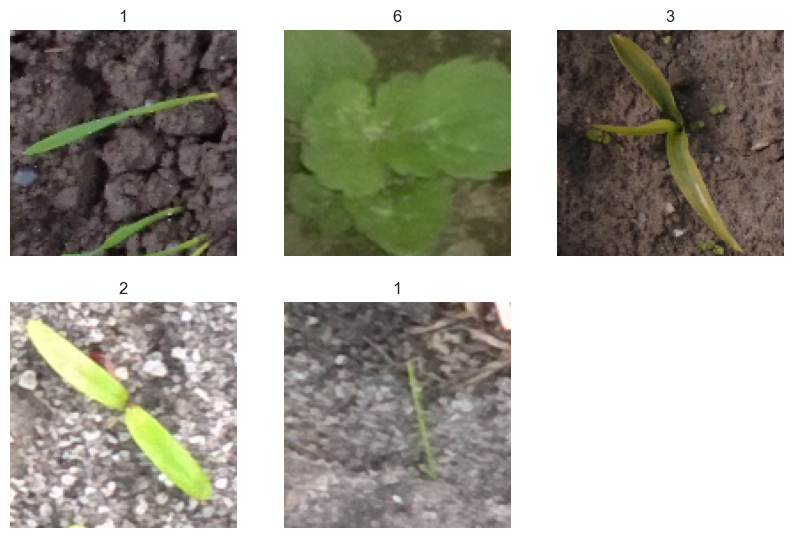

In [7]:
plt.figure(figsize=(10, 10))
for img, labels in train_data.take(1):
  lbl=labels.numpy()
  for i in range(5):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img[i].numpy().astype("uint8"))
    plt.title(class_names[lbl[i]])
    plt.axis("off")

In [8]:
X_train = np.concatenate([x for x, y in train_data], axis=0)
y_train = np.concatenate([y for x, y in train_data], axis=0)

X_val = np.concatenate([x for x, y in validation_data], axis=0)
y_val = np.concatenate([y for x, y in validation_data], axis=0)

X_test = np.concatenate([x for x, y in test_data], axis=0)
y_test = np.concatenate([y for x, y in test_data], axis=0)

In [9]:
#Normalization
X_train = X_train / 255
X_val = X_val / 255
X_test = X_test / 255

## Part 1a. Transfer Learning - Classification Network (3 Marks)
For this assignment, you are asked to use the Keras implementation of VGG-16 as a starting point.

Using the first 2 blocks of VGG-16 add extra Keras layers to create your own version of a CNN network for the classification of the images according to the number of leaves in the plant images. Note that there will be 5 classes. The last layer from VGG-16 will be block2 pool and you are allowed to add no more than five fully connected or convolutional layers to the network including the final output layer.

- You can use as many pooling, flattening, 1 × 1 convolution layers, etc. as you wish but do not use any regularization.
- Train this simple network on the training set while monitoring convergence on the validation set.
- As input to the model use images of size no larger than 128×128.

Note, it is highly recommended to use even smaller input images to try things out. You are not expected to fine-tune the initial VGG layers.

When your classifier is working:
- Plot a loss curve for training and validation data
- Plot an accuracy curve for training and validation data
- Provide confusion matrix of your network on the training including validation and testing data sets.


In [17]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
num_epoch = 100

In [18]:
vgg_model = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(128,128, 3))

In [19]:
s_layer = vgg_model.layers[6].output
x= Conv2D(512, kernel_size=5, activation='relu', padding='same')(s_layer)
x= MaxPooling2D(pool_size=(2, 2))(x)
x= Conv2D(256, kernel_size=3, activation='relu', padding='same')(x)
x= MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(256, activation = "relu")(x)
x = Dense(128, activation = "relu")(x)
x = Dense(5, activation='softmax')(x)

vgg_model_transfer = Model(inputs=vgg_model.input, outputs=x)

In [20]:
vgg_model_transfer.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

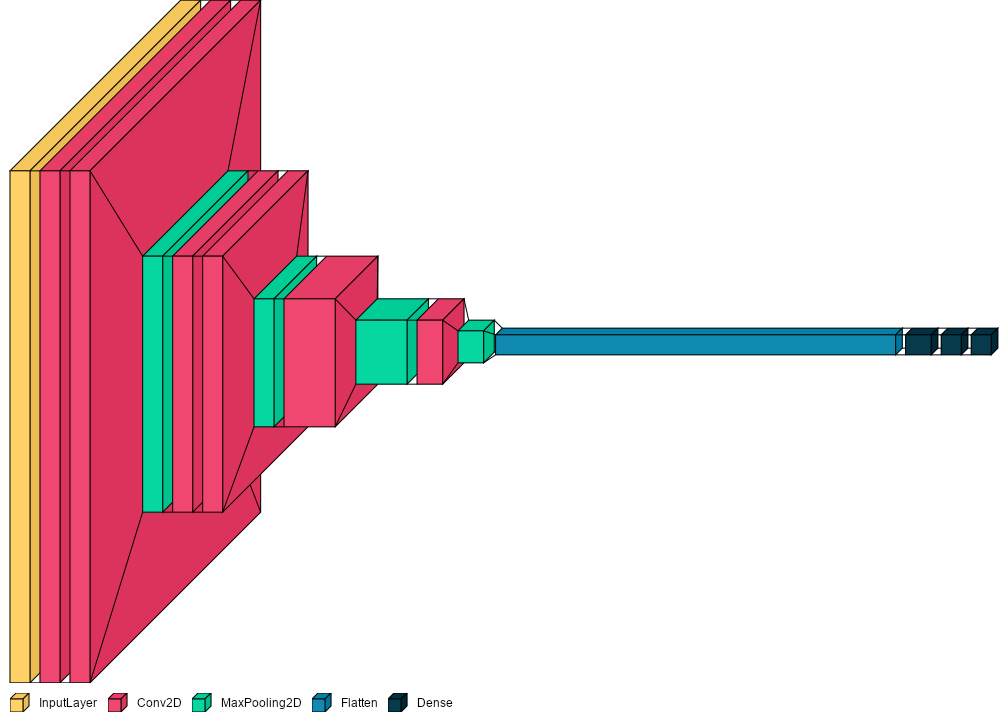

In [21]:
font = ImageFont.truetype("arial.ttf", 12)
visualkeras.layered_view(vgg_model_transfer, legend=True, font=font)

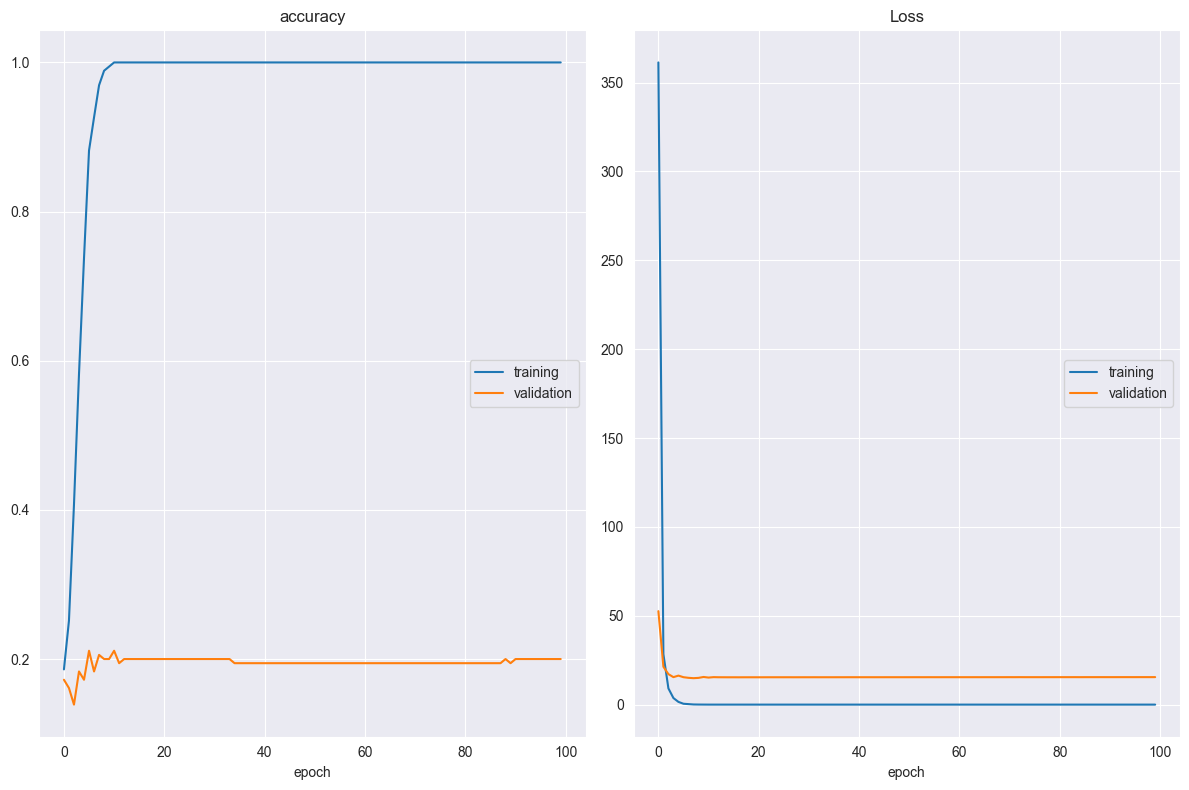

accuracy
	training         	 (min:    0.186, max:    1.000, cur:    1.000)
	validation       	 (min:    0.139, max:    0.211, cur:    0.200)
Loss
	training         	 (min:    0.000, max:  361.353, cur:    0.000)
	validation       	 (min:   14.877, max:   52.595, cur:   15.472)
23/23 - 3s - loss: 6.2743e-05 - accuracy: 1.0000 - val_loss: 15.4723 - val_accuracy: 0.2000 - 3s/epoch - 109ms/step


In [22]:
vgg_model_transfer.compile(loss='sparse_categorical_crossentropy',
                           optimizer=opt,
                           metrics=['accuracy'])
history = vgg_model_transfer.fit(X_train,y_train, batch_size=BATCH_SIZE, epochs=num_epoch, verbose=2,
                                 validation_data=(X_val,y_val),callbacks= [PlotLossesKeras()])

In [54]:
pre_train =  np.argmax(vgg_model_transfer.predict(X_train),axis=1)
pre_val =  np.argmax(vgg_model_transfer.predict(X_val),axis=1)
pre_test =  np.argmax(vgg_model_transfer.predict(X_test),axis=1)

4/4 [==============================] - 1s 210ms/step


In [60]:
cl_train_acc = accuracy_score(y_train,pre_train)
cl_val_acc = accuracy_score(y_val,pre_val)
cl_test_acc = accuracy_score(y_test,pre_test)
print("Train accuracy in Classification part is --> ", cl_train_acc)
print("Validation accuracy in Classification part is --> ", cl_val_acc)
print("Test accuracy in Classification part is --> ", cl_test_acc)

Train accuracy in Classification part is -->  1.0
Validation accuracy in Classification part is -->  0.2
Test accuracy in Classification part is -->  0.22


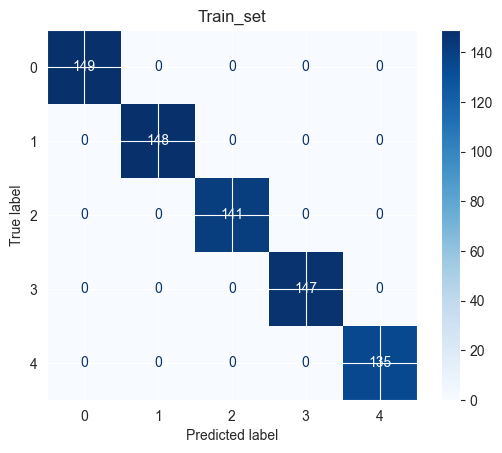

In [61]:
con_matrix(y_train,pre_train,'Train_set')

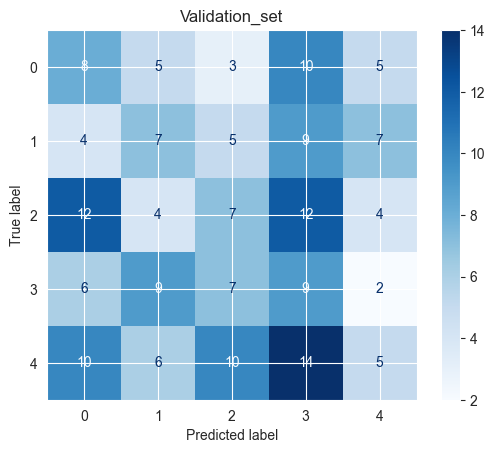

In [62]:
con_matrix(y_val,pre_val,'Validation_set')

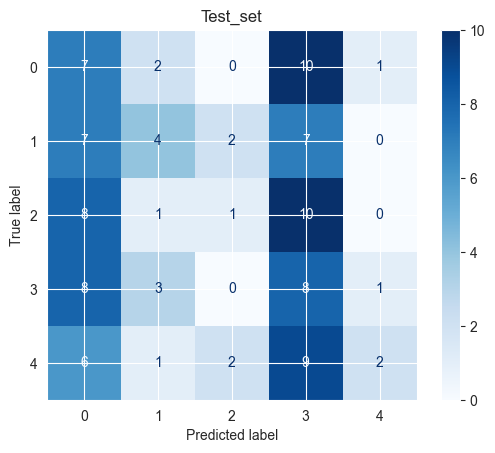

In [63]:
con_matrix(y_test,pre_test,'Test_set')

## Part 1b. Transfer Learning - Regression Reformulation (3 Marks)

### Step 1 (2)
Repeat the steps of Part 1a. but reformulate as a regression problem, i.e., your network needs to output a single float value ranging between 0 to 6 corresponding to the number of leaves. Again, you are not expected to fine-tune the initial VGG layers.

- Plot a loss curve for training and validation data
- Plot an accuracy curve for training and validation data
- Provide confusion matrix of your network on the training including validation and testing data sets.

### Step 2 (1)
The size of the training data is quite small. Discuss based on your learning curves if overfitting is occurring with the models from Parts 1a and 1b.

In [48]:
y_mapped = {0:1, 1:2, 2:3,3:4, 4:6}

y_t = np.array([y_mapped[key] for key in y_train]).astype(float)
y_v = np.array([y_mapped[key] for key in y_val]).astype(float)
y_ts = np.array([y_mapped[key] for key in y_test]).astype(float)

In [49]:
model_regression =VGG16(
    include_top=False, weights='imagenet',
    input_shape=(128,128,3))

In [50]:
for layer in model_regression.layers:
    layer.trainable = False

x = model_regression.layers[6].output
x= Conv2D(512, kernel_size=5, activation='relu', padding='same')(x)
x= MaxPooling2D(pool_size=(2, 2))(x)
x= Conv2D(256, kernel_size=3, activation='relu', padding='same')(x)
x= MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(256, activation = "relu")(x)
x = Dense(128, activation = "relu")(x)
x = Dense(1, activation='linear')(x)
vgg_regression = Model(inputs=model_regression.input, outputs=x)

In [51]:
vgg_regression.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

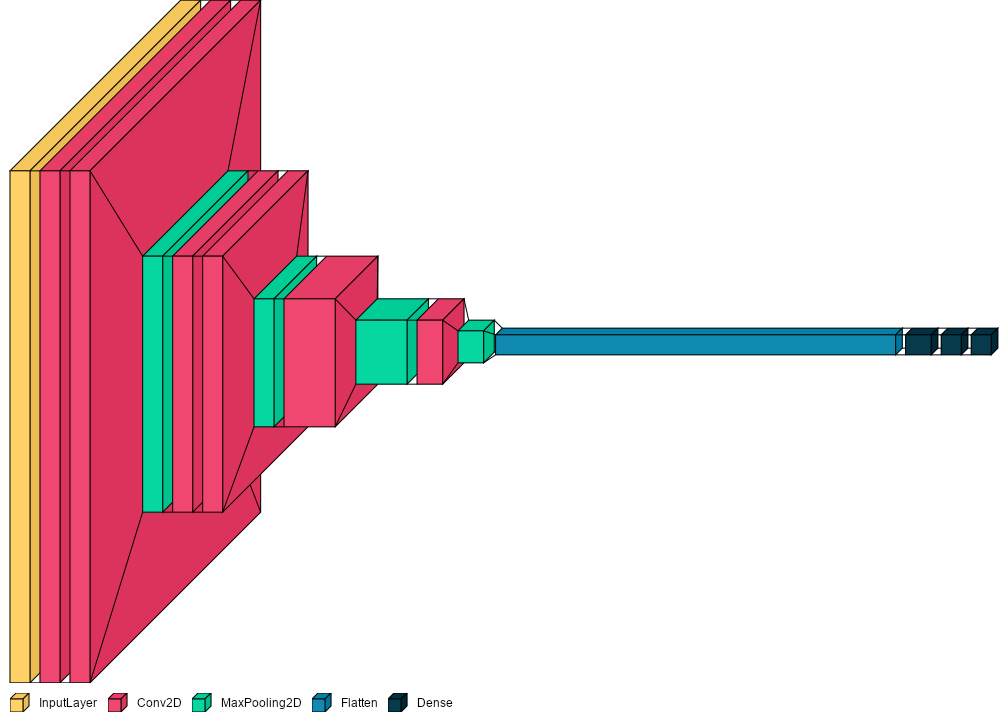

In [52]:
font = ImageFont.truetype("arial.ttf", 12)
visualkeras.layered_view(vgg_regression, legend=True, font=font)

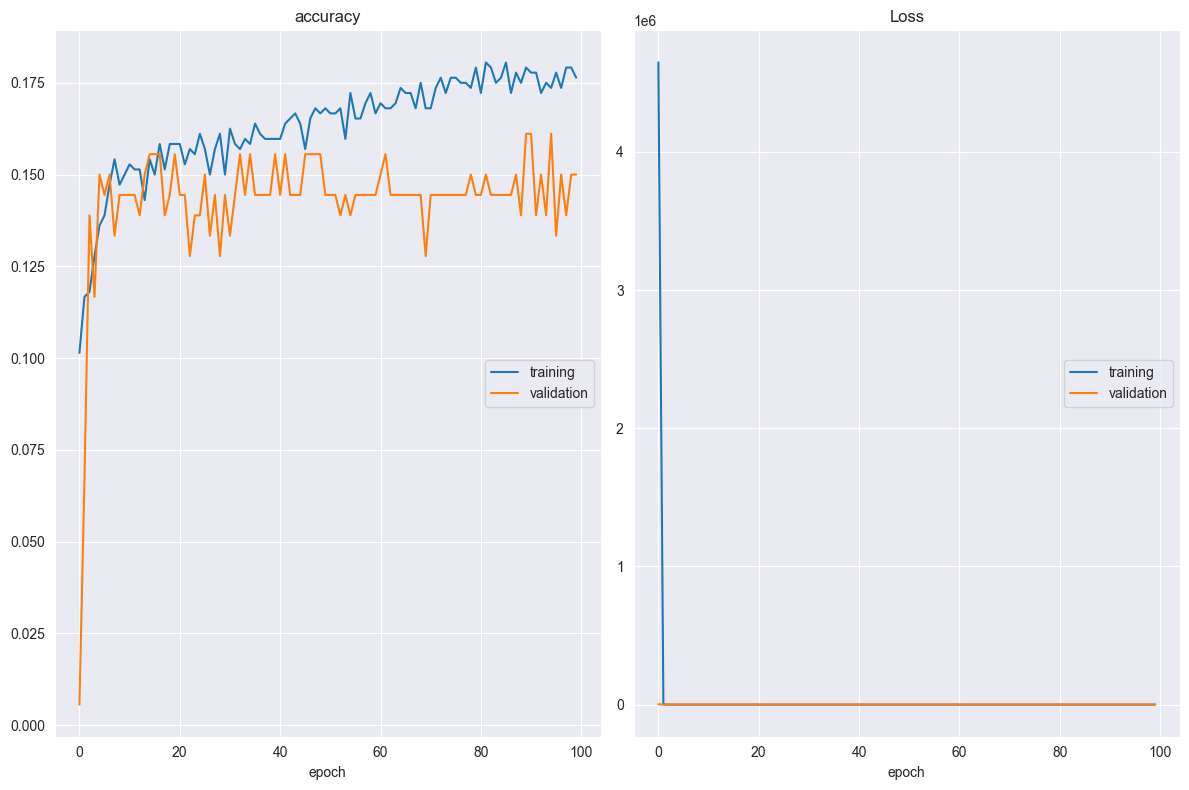

accuracy
	training         	 (min:    0.101, max:    0.181, cur:    0.176)
	validation       	 (min:    0.006, max:    0.161, cur:    0.150)
Loss
	training         	 (min:    5.529, max: 4647006.000, cur:    5.529)
	validation       	 (min:   14.084, max: 2138.997, cur:   14.150)
23/23 - 1s - loss: 5.5290 - accuracy: 0.1764 - val_loss: 14.1500 - val_accuracy: 0.1500 - 1s/epoch - 58ms/step


In [53]:
vgg_regression.compile(loss='mean_squared_error',optimizer=opt,metrics=['accuracy'])
history_regreesion = vgg_regression.fit(X_train, y_t, batch_size=BATCH_SIZE, epochs=num_epoch, verbose=2
                                        ,validation_data=(X_val,y_v),callbacks= [PlotLossesKeras()])

In [65]:
pre_train1 =vgg_regression.predict(X_train)
pre_val1 =vgg_regression.predict(X_val)
pre_test1 =vgg_regression.predict(X_test)

4/4 [==============================] - 0s 25ms/step


In [66]:
def mapping(data):
    e_list = []
    for i in data:
        number = i
        pred =int(number)
        if number - int(number) >=0.5 :
            pred = int(number) +1
            if pred >= 5 :
               pred =6
        e_list.append(pred)
    return e_list

In [67]:
pre_train_mapped = mapping(pre_train1)
pre_val1_mapped = mapping(pre_val1)
pre_test1_mapped = mapping(pre_test1)

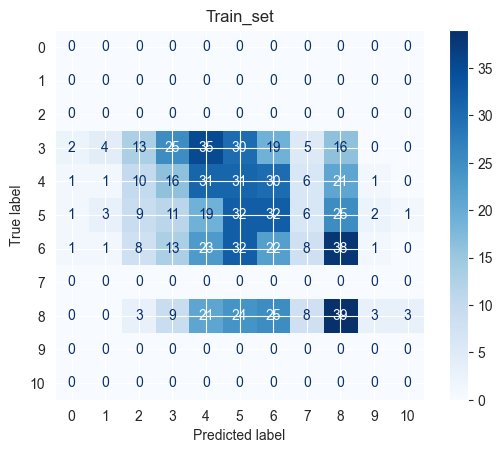

In [72]:
con_matrix(y_t,pre_train_mapped,'Train_set')

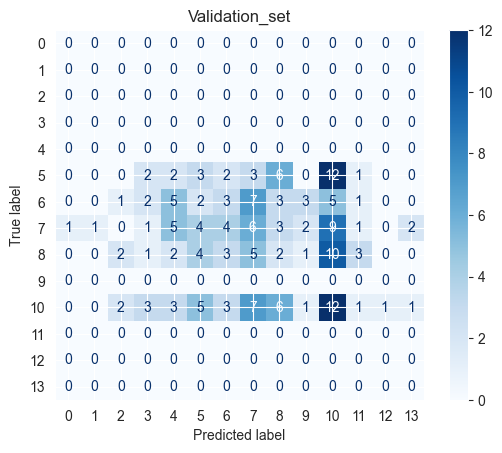

In [70]:
con_matrix(y_v, pre_val1_mapped, 'Validation_set')

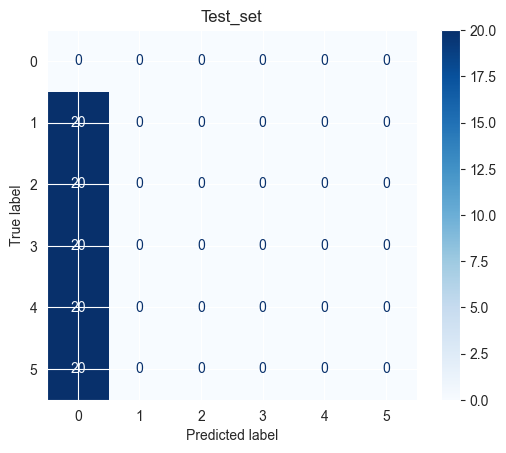

In [71]:
con_matrix(y_ts, pre_test1_mapped, 'Test_set')

For the Classification part model is overfitted in training data and can not learn so, the test accurcy is 20%.
For Regression part model also can not learn or converge but train and validation values get close to each other.

## Part 2. Improve your Model (4 Marks)

Regularization and data augmentation are common strategies to deal with small datasets.

### Step 1 (1.5)
Incorporate Batch Normalization and Dropout into your design the superior network trained in Part 1. You are not expected to fine-tune the initial VGG layers. Again you will provide the following:
- A loss curve for training and validation data
- An accuracy curve for training and validation data
- A confusion matrix of your network on the training including validation and testing data sets.


### Step 2 (1.5)
Train the same model from Step 1, now using data augmentation. Again, please provide the same output metrics as in Step 1.

### Step 3 (1)
Discuss based on your learning curves and final metrics in Step 2, how large a improvement can be observed from regularization and data augmentation.

## Regularization

In [117]:
vgg_model_regualized = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(128, 128, 3))

In [118]:
from keras.layers import BatchNormalization

for layer in vgg_model_regualized.layers:
    layer.trainable = False

x = vgg_model_regualized.layers[6].output
x= Conv2D(512, kernel_size=5, activation='relu', padding='same')(x)
x= MaxPooling2D(pool_size=(2, 2))(x)
x= Conv2D(256, kernel_size=3, activation='relu', padding='same')(x)
x= MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(256, activation = "relu")(x)
x = BatchNormalization()(x)
x = Dense(128, activation = "relu")(x)
x = Dropout(0.02)(x)
x = Dense(5, activation='relu')(x)
vgg_model_transferL = Model(inputs=vgg_model_regualized.input, outputs=x)

In [119]:
vgg_model_transferL.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

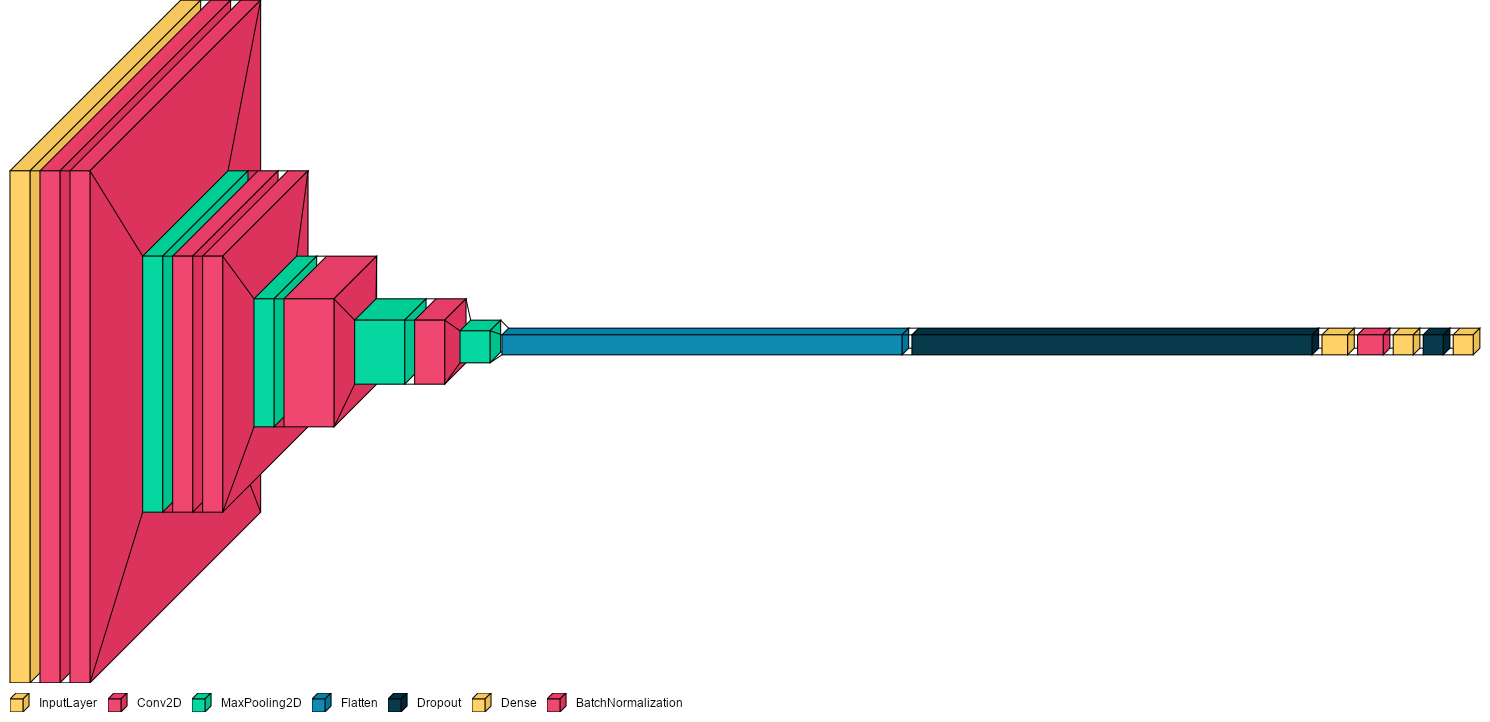

In [120]:
font = ImageFont.truetype("arial.ttf", 12)
visualkeras.layered_view(vgg_model_transferL, legend=True, font=font)

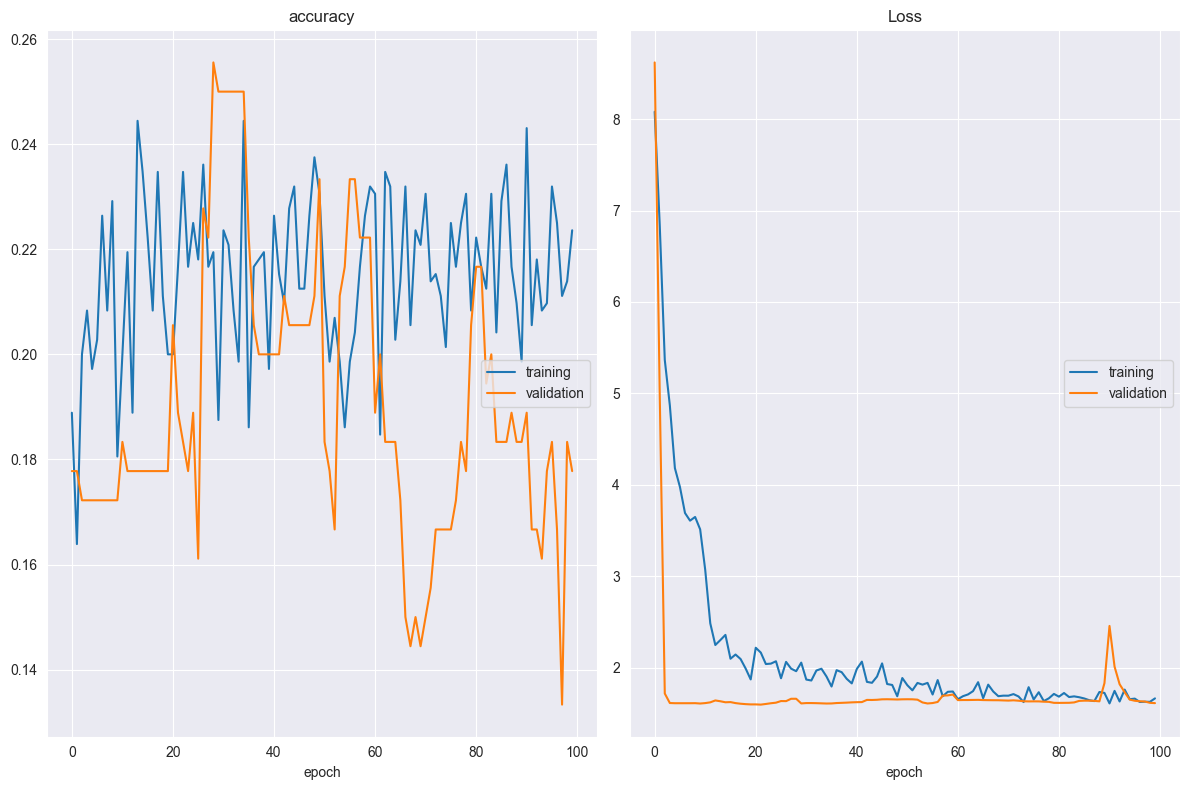

accuracy
	training         	 (min:    0.164, max:    0.244, cur:    0.224)
	validation       	 (min:    0.133, max:    0.256, cur:    0.178)
Loss
	training         	 (min:    1.607, max:    8.081, cur:    1.662)
	validation       	 (min:    1.594, max:    8.620, cur:    1.610)
12/12 - 1s - loss: 1.6623 - accuracy: 0.2236 - val_loss: 1.6104 - val_accuracy: 0.1778 - 1s/epoch - 110ms/step


In [121]:
vgg_model_transferL.compile(loss='sparse_categorical_crossentropy',
                           optimizer=opt,
                           metrics=['accuracy'])
historyL = vgg_model_transferL.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=num_epoch, verbose=2,
                                 validation_data=(X_val, y_val),callbacks= [PlotLossesKeras()])

## Data Augmentation

In [143]:
from keras_preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        brightness_range=[0.2,1.2],fill_mode='nearest')

In [144]:
train_generator = datagen.flow_from_directory(
                  directory=train_path,
                  target_size=(128, 128),
                  color_mode="rgb",
                  batch_size=1,
                  class_mode="binary",
                  seed=2020
)

Found 900 images belonging to 5 classes.


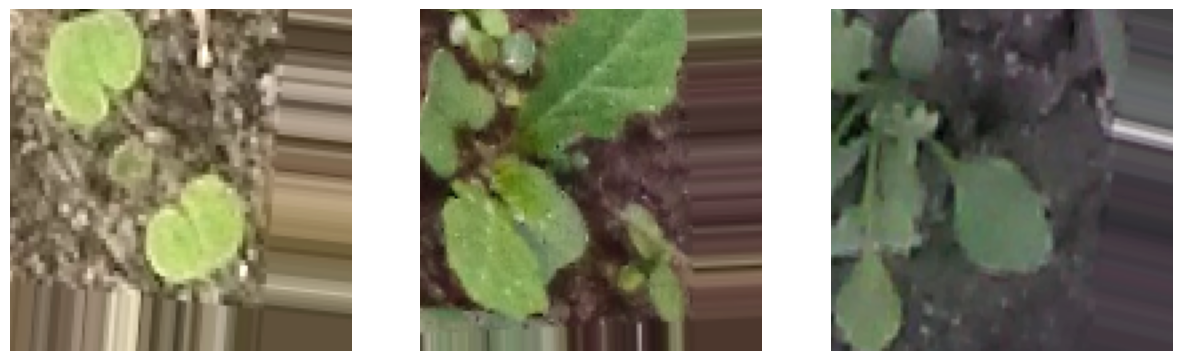

In [145]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,15))
for i in range(3):
  image = next(train_generator)[0].astype('uint8')
  image = np.squeeze(image)
  ax[i].imshow(image)
  ax[i].axis('off')

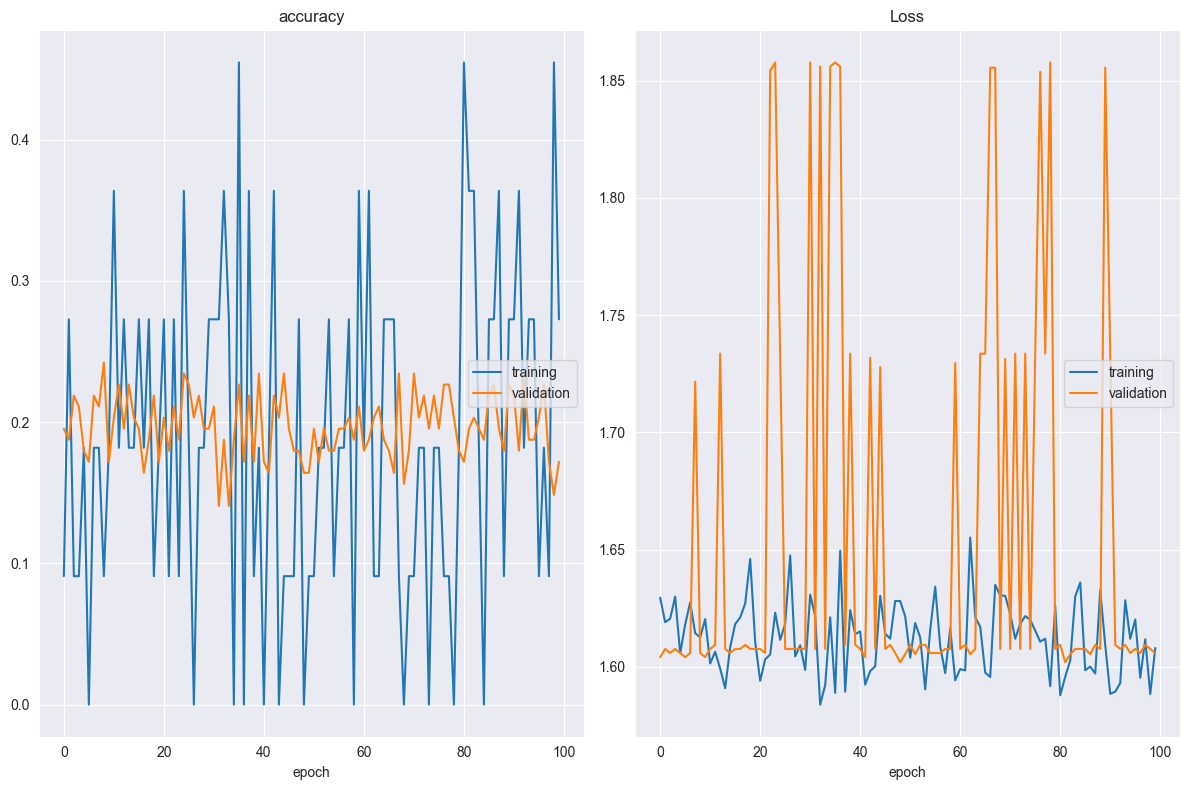

accuracy
	training         	 (min:    0.000, max:    0.455, cur:    0.273)
	validation       	 (min:    0.141, max:    0.242, cur:    0.172)
Loss
	training         	 (min:    1.584, max:    1.655, cur:    1.608)
	validation       	 (min:    1.602, max:    1.858, cur:    1.606)
11/11 [==============================] - 1s 60ms/step - loss: 1.6081 - accuracy: 0.2727 - val_loss: 1.6060 - val_accuracy: 0.1719


In [146]:
historyL = vgg_model_transferL.fit_generator(train_generator, steps_per_epoch=(len(X_train) * 0.8) // 64,
                                             epochs=num_epoch,
                                             validation_data=validation_data,
                                             validation_steps=(len(X_train) * 0.2) // 64, callbacks=[PlotLossesKeras()])

In Regularization, model is underfitted on training and validation but accuracies is close to each others, and assumed model need more data.
so, data augmentation was preformed but  didn't help in improving the accuracy over the training or validation data as the model wasn't able to learn.

overall the model can't learn in training or validation data.

## References
[1] N. Teimouri, M. Dyrmann, P. R. Nielsen, S. K. Mathiassen, G. J. Somerville, and R. N. Jørgensen, “Weed growth stage estimator using deep convolutional neural networks,” Sensors, vol. 18, no. 5, 2018.

[2] https://kaggle.com/code/mohammednamory/leaf-counting-using-regression-and-classification. Accessed 22 Nov. 2022.